In [816]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

np.random.seed(123)
tf.random.set_seed(123)

In [817]:
from sklearn.metrics import mean_absolute_percentage_error

In [1007]:
df = pd.read_csv('PanDA_queues.csv', index_col='datetime', parse_dates=True)

In [1008]:
df['queue'].values

array(['ANALY_FZU_VP_2', 'ANALY_LRZ_VP', 'ANALY_MANC_GPU', ...,
       'ANALY_BNL_VP', 'ANALY_CERN-P1_COVID', 'ANALY_CERN_T0_ART'],
      dtype=object)

In [1009]:
df = df[df['queue']=='BNL'][['queue_utilization']]

In [1010]:
df.index = pd.to_datetime(df.index, format='YYYY-MM-DD HH:MI:SS')

In [1011]:
df.head()

,queue_utilization
datetime,
2022-04-26 21:00:00,1.5857
2022-04-26 22:00:00,0.7268
2022-04-26 23:00:00,1.0063
2022-04-27 00:00:00,1.1651
2022-04-27 01:00:00,1.5849


In [1012]:
df = df[~df.index.duplicated()]

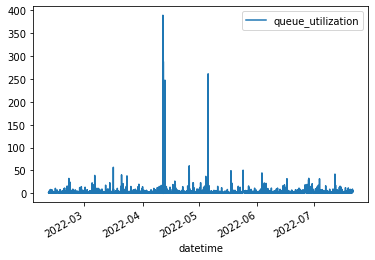

In [1013]:
df.plot();

In [1014]:
df = df[['queue_utilization']].sort_index()

In [1015]:
df['queue_utilization'] = df['queue_utilization'].apply(lambda x: x if x > 0.0000 else 0.0001)

In [1016]:
df[['queue_utilization']]

,queue_utilization
datetime,
2022-02-10 00:00:00,1.4031
2022-02-10 01:00:00,1.6551
2022-02-10 02:00:00,0.0560
2022-02-10 03:00:00,0.0121
2022-02-10 04:00:00,2.4640
...,...
2022-07-21 13:00:00,3.6708
2022-07-21 14:00:00,2.1237
2022-07-21 15:00:00,2.2795


In [1017]:
df = df.asfreq('1H')

In [1018]:
df = df.fillna(0.0001)

In [1019]:
df['LogUtilization'] = np.log(df['queue_utilization'])

In [1020]:
df.shape

(3882, 2)

In [1021]:
df.head(10)

,queue_utilization,LogUtilization
datetime,,
2022-02-10 00:00:00,1.4031,0.338684
2022-02-10 01:00:00,1.6551,0.503861
2022-02-10 02:00:00,0.0560,-2.882404
2022-02-10 03:00:00,0.0121,-4.414550
2022-02-10 04:00:00,2.4640,0.901786
2022-02-10 05:00:00,3.7291,1.316167
2022-02-10 06:00:00,4.3764,1.476226
2022-02-10 07:00:00,3.1116,1.135137
2022-02-10 08:00:00,1.8137,0.595369


In [1022]:
df[['LogUtilization']].isna().sum()

LogUtilization    0
dtype: int64

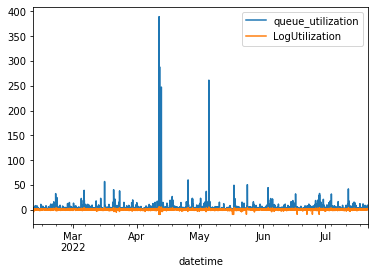

In [1023]:
df.plot();

In [1024]:
df['DiffLogUtilization'] = df['LogUtilization'].diff()

In [1027]:
Ntest = 3
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [1028]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[['DiffLogUtilization']])
test_scaled = scaler.fit_transform(test[['DiffLogUtilization']])

In [1029]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1] # indexes less than the last values of train
test_idx = df.index > train.index[-1] # indexes greater than the last value of train

In [1030]:
df.loc[train_idx, 'ScaledDiffLogUtilization'] = train_scaled.flatten()
df.loc[test_idx, 'ScaledDiffLogUtilization'] = test_scaled.flatten()

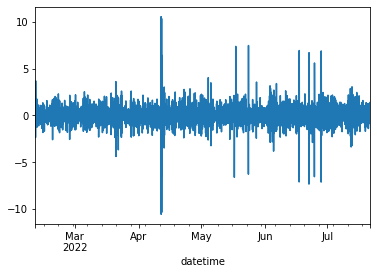

In [1031]:
df['ScaledDiffLogUtilization'].plot();

In [1032]:
df.shape

(3882, 4)

In [1033]:
# make supervised dataset

series = df['ScaledDiffLogUtilization'].dropna().to_numpy()

T = 10 # number of lags
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (3871, 10) Y.shape (3871,)


In [1034]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [1035]:
# Basic ANN
i = Input(shape=(T,))
x = Dense(32, activation='relu')(i)
x = Dense(1)(x)
model = Model(i, x)

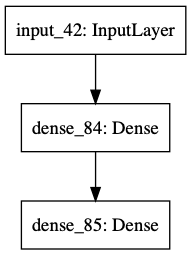

In [1036]:
tf.keras.utils.plot_model(model)

In [1037]:
model.compile(
    loss='mse',
    optimizer='adam',
    metrics='mae'
)

In [1038]:
r = model.fit(
    Xtrain,
    Ytrain,
    epochs=200,
    validation_data=(Xtest, Ytest)
)

Epoch 1/200
121/121 [==============================] - 0s 1ms/step - loss: 0.9023 - mae: 0.6490 - val_loss: 0.7915 - val_mae: 0.8563
Epoch 2/200
121/121 [==============================] - 0s 704us/step - loss: 0.7984 - mae: 0.6086 - val_loss: 0.7230 - val_mae: 0.8220
Epoch 3/200
121/121 [==============================] - 0s 754us/step - loss: 0.7532 - mae: 0.5913 - val_loss: 0.6540 - val_mae: 0.7770
Epoch 4/200
121/121 [==============================] - 0s 661us/step - loss: 0.7266 - mae: 0.5832 - val_loss: 0.5983 - val_mae: 0.7593
Epoch 5/200
121/121 [==============================] - 0s 703us/step - loss: 0.7113 - mae: 0.5762 - val_loss: 0.5677 - val_mae: 0.7293
Epoch 6/200
121/121 [==============================] - 0s 646us/step - loss: 0.7005 - mae: 0.5732 - val_loss: 0.5775 - val_mae: 0.7334
Epoch 7/200
121/121 [==============================] - 0s 693us/step - loss: 0.6892 - mae: 0.5692 - val_loss: 0.5814 - val_mae: 0.7260
Epoch 8/200
121/121 [==============================] - 0s

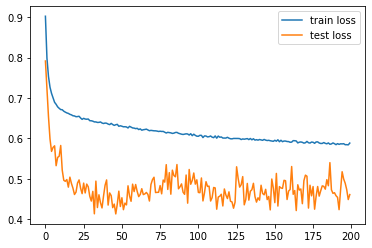

In [1039]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [1040]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [1041]:
Ptrain = model.predict(Xtrain).flatten() # turn to 1D array
Ptest = model.predict(Xtest).flatten()

In [1042]:
# Store diff predictions
df.loc[train_idx, 'Scaled Diff ANN Train Prediction'] = Ptrain
df.loc[test_idx, 'Scaled Diff ANN Test Prediction'] = Ptest

In [1043]:
Ptest

array([-0.14200169,  0.37133265, -0.49891478], dtype=float32)

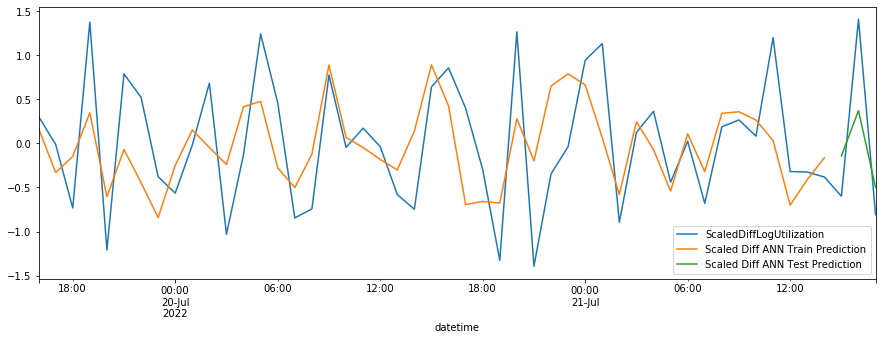

In [1044]:
cols = ['ScaledDiffLogUtilization',
        'Scaled Diff ANN Train Prediction',
        'Scaled Diff ANN Test Prediction']
df[cols].tail(50).plot(figsize=(15,5));

In [1045]:
# Needed to compute un-differenced predictions
df['ShiftLogUtilization'] = df['LogUtilization'].shift(1)
prev = df['ShiftLogUtilization']

In [1046]:
# Last-known train value
last_train = train.iloc[-1]['LogUtilization']

In [1047]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

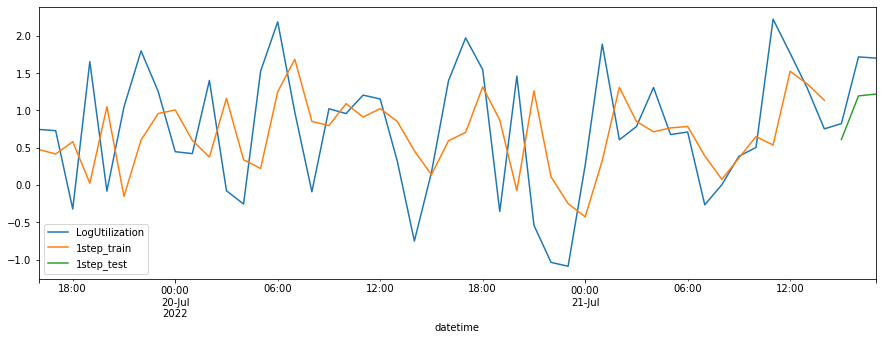

In [1048]:
# plot 1-step forecast
df[['LogUtilization', '1step_train', '1step_test']].tail(50).plot(figsize=(15,5));

In [1049]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1,-1))[0]

    # update the predictions list
    multistep_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

In [1050]:
# save multistep forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

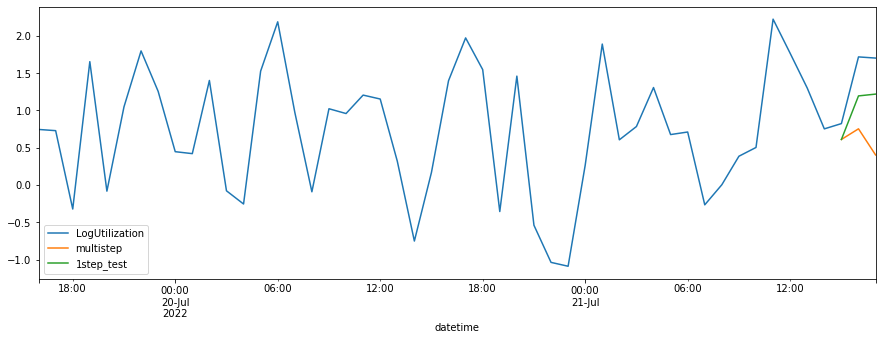

In [1051]:
cols = ['LogUtilization', 'multistep', '1step_test']
df[cols].tail(50).plot(figsize=(15,5));

In [1052]:
# make multi-output supervised dataset
Tx = T # number of step in the input
Ty = Ntest # number of steps in the output
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (3869, 10) Y.shape (3869, 3)


In [1053]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [1054]:
# Basic ANN
i = Input(shape=(Tx,))
x = Dense(32, activation='relu')(i)
x = Dense(Ty)(x)
model = Model(i,x)

In [1055]:
model.compile(
    loss='mse',
    optimizer='adam'
)

In [1056]:
r = model.fit(
    Xtrain_m,
    Ytrain_m,
    epochs=100,
    validation_data=(Xtest_m, Ytest_m)
)

Epoch 1/100
121/121 [==============================] - 0s 1ms/step - loss: 1.1655 - val_loss: 1.1701
Epoch 2/100
121/121 [==============================] - 0s 688us/step - loss: 1.0132 - val_loss: 1.2036
Epoch 3/100
121/121 [==============================] - 0s 705us/step - loss: 0.9766 - val_loss: 1.2521
Epoch 4/100
121/121 [==============================] - 0s 688us/step - loss: 0.9545 - val_loss: 1.2319
Epoch 5/100
121/121 [==============================] - 0s 682us/step - loss: 0.9389 - val_loss: 1.2021
Epoch 6/100
121/121 [==============================] - 0s 700us/step - loss: 0.9288 - val_loss: 1.1960
Epoch 7/100
121/121 [==============================] - 0s 754us/step - loss: 0.9180 - val_loss: 1.1635
Epoch 8/100
121/121 [==============================] - 0s 882us/step - loss: 0.9113 - val_loss: 1.1356
Epoch 9/100
121/121 [==============================] - 0s 715us/step - loss: 0.9047 - val_loss: 1.1295
Epoch 10/100
121/121 [==============================] - 0s 728us/step - los

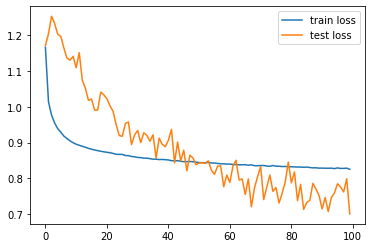

In [1057]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend();

In [1058]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

In [1059]:
Ptrain.shape, Ptest.shape

((3868, 3), (1, 3))

In [1060]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [1061]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)

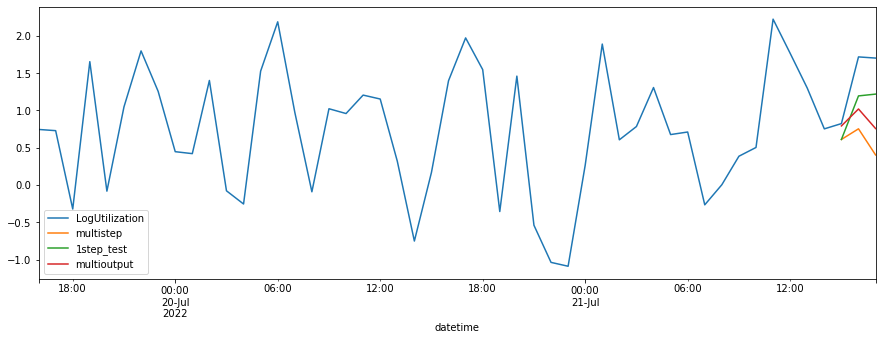

In [1062]:
# plot all forecasts
cols = ['LogUtilization','multistep','1step_test','multioutput']
df[cols].tail(50).plot(figsize=(15,5));

In [1063]:
# MAPE
test_log_loss = df.iloc[-Ntest:]['LogUtilization']
mape1 = mean_absolute_percentage_error(test_log_loss, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)

mape2 = mean_absolute_percentage_error(test_log_loss, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.5275451318097873
multi-output MAPE: 0.33322113158264527
